In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# !pip install bayesian-optimization

In [5]:
ran_seed = 2023

In [6]:
# !pip install missingno

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno

from tqdm.notebook import tqdm
from math import sqrt

from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import Lasso,Ridge
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
# import lightgbm as lgbm
# from xgboost import XGBClassifier

# from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial #함수 고정

### 데이터 프레임 준비(사용할 컬럼중 카테고리 컬럼은 compression과 원본 비교)

In [7]:
# variable의 col이름은 더미변수를 한 컬럼으로 다시 함친것이기 때문에 해당 변수의 이름이 다르다.
def make_df(df_path, variables_path):
    df = pd.read_pickle(df_path)
    variables = pd.read_csv(variables_path)
    
    target_col = "depvar"
    target_df = df[target_col]
    use_col = variables.loc[variables["use_or_not"] == "use" , "columns"]
    use_df = df[use_col]
    print("-"*20, "사용 변수 출력", "-"*20)
    # for col in use_col:
    #     print(f"{col}: [{df.dtypes[col]} ,{len(df[col].unique())}]")
    #     print(list(variables.loc[variables["columns"]==col, "explain"])[0])
    #     print("-"*50)
    return use_df, target_df, use_col

In [8]:
df_path = "datacompression_lendingclub.pkl"
variables_path = "variable_use.csv"

use_df, target_df, use_col = make_df(df_path, variables_path);
print(use_df.shape , target_df.shape, use_col.shape)

-------------------- 사용 변수 출력 --------------------
(874335, 22) (874335,) (22,)


카테고리: home_ownership, verfification_status, purpose

In [8]:
## fico average column 생성, column drop
use_df["fico_average"] = (use_df["fico_range_high"] + use_df["fico_range_low"])/2
use_df.drop(["fico_range_high", "fico_range_low"], axis=1, inplace=True)
use_df.head(2)

,loan_amnt,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,last_fico_range_high,last_fico_range_low,...,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,home_ownership,verification_status,purpose,emp_length,fico_average
0,12000,90641.0,10.2,0,1,5,0,0.405,584,580,...,27898,0,0,0,0,6.0,1.0,3.0,2.0,692.0
1,14000,46000.0,17.4,1,0,9,0,0.664,724,720,...,19286,0,0,0,0,6.0,1.0,3.0,2.0,672.0


In [9]:
# last fico에 대한 last_fico_range_big 이라는 컬럼 생성
use_df.loc[(use_df["last_fico_range_high"] - use_df["last_fico_range_low"])==499, "last_fico_range_big"] = 1
use_df.loc[(use_df["last_fico_range_high"] - use_df["last_fico_range_low"])!=499, "last_fico_range_big"] = 0

In [10]:
#카테고리 피쳐 변환
categorical_feats = ["home_ownership", "verification_status", "purpose", "last_fico_range_big"]
for c in categorical_feats:
    use_df[c] = use_df[c].astype('category')

In [11]:
## emp_length 변경
length = [[1, 1], [2, 10], [3, 2], [4, 3], [5, 4], [6, 5], [7, 6], [8, 7], [9, 8], [10, 9], [11, 0], [12, np.nan]]
use_df["new_emp_length"] = np.nan*use_df.shape[0]

for i in length:
    num, value = i[0], i[1]
    use_df.loc[use_df["emp_length"]==num, "new_emp_length"] = value
    # print(num, value)
    # print(use_df["new_emp_length"].value_counts())
    # print("-"*40)

use_df.drop(["emp_length"], axis=1, inplace=True)

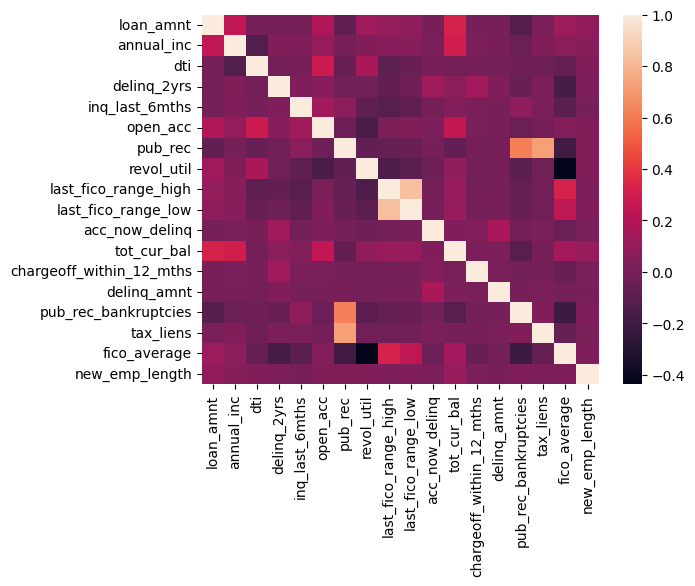

In [12]:
# colleration 재확인
sns.heatmap(use_df.corr());

In [12]:
#카테고리 피쳐 변환
categorical_feats = ["home_ownership", "verification_status", "purpose", "last_fico_range_big"]
for c in categorical_feats:
    use_df[c] = use_df[c].astype(str)

In [13]:
use_df.columns

Index(['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_util', 'last_fico_range_high', 'last_fico_range_low',
       'acc_now_delinq', 'tot_cur_bal', 'chargeoff_within_12_mths',
       'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'home_ownership',
       'verification_status', 'purpose', 'last_fico_range_big',
       'new_emp_length'],
      dtype='object')

In [14]:
#새로 만든 변수 확인
set(use_df.columns) - set(use_col)

{'last_fico_range_big', 'new_emp_length'}

In [15]:
#삭제변수 확인
set(use_col) - set(use_df.columns)

{'emp_length', 'fico_range_high', 'fico_range_low'}

In [16]:
use_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874335 entries, 0 to 874334
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   loan_amnt                 874335 non-null  int32  
 1   annual_inc                874335 non-null  float64
 2   dti                       874335 non-null  float64
 3   delinq_2yrs               874335 non-null  int8   
 4   inq_last_6mths            874335 non-null  int8   
 5   open_acc                  874335 non-null  int16  
 6   pub_rec                   874335 non-null  int8   
 7   revol_util                874335 non-null  float64
 8   last_fico_range_high      874335 non-null  int16  
 9   last_fico_range_low       874335 non-null  int16  
 10  acc_now_delinq            874335 non-null  int8   
 11  tot_cur_bal               874335 non-null  int32  
 12  chargeoff_within_12_mths  874335 non-null  int8   
 13  delinq_amnt               874335 non-null  i

### 데이터 준비(train, test split)

In [15]:
def train_test(use_df, target_df, test_size=0.2, random_state=2023):
    x_train, x_test, y_train, y_test = train_test_split(use_df, target_df, test_size=test_size, random_state=random_state, stratify=target_df) #shuffle false라고 생각했는데 shuffle True라고 했을때 random state를 설정하는 의미가 있다고 나옴

    # k-fold 사용해주기 위해서 (x_train, y_train) index 다시 설정
    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    #test_size 확인
    print(f"test_size: {x_test.shape[0]/use_df.shape[0]*100}%")

    #shape 확인
    print("x_train.shape: ", x_train.shape)
    print("x_test.shape: ", x_test.shape)
    print("y_train.shape: ", y_train.shape)
    print("y_test.shape: ", y_test.shape)

    #train, test 클래스 비율 확인
    print(f"train positive 비율: {pd.Series(y_train).value_counts()[1]/len(pd.Series(y_train))}")
    print(f"test positive 비율: {pd.Series(y_test).value_counts()[1]/len(pd.Series(y_test))}")

    return x_train, x_test, y_train, y_test

In [16]:
x_train, x_test, y_train, y_test = train_test(use_df, target_df, test_size=0.2, random_state=2023)

test_size: 20.0%
x_train.shape:  (699468, 23)
x_test.shape:  (174867, 23)
y_train.shape:  (699468,)
y_test.shape:  (174867,)
train positive 비율: 0.16204601211206232
test positive 비율: 0.16204887142799956


### Grid search 를 통한 catboost parameter 탐색

In [1]:
skf = StratifiedKFold(n_splits = 5,random_state = ran_seed,shuffle=True)

NameError: name 'StratifiedKFold' is not defined

In [25]:

params = {'iterations': [1000],
          'depth': [4, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': [3,5,10],
          'learning_rate':[0.01,0.1,0.3],
          'leaf_estimation_iterations': [10],
          'eval_metric': ['AUC'],
          'use_best_model': [True],
          'random_seed': [ran_seed],
          'verbose':[1],
          'early_stopping_rounds' : [100]
         }


In [24]:
model = CatBoostClassifier()

In [30]:
grid_cat = GridSearchCV(estimator = model,param_grid = params,scoring = 'roc_auc' ,verbose = 1,cv = skf)

In [32]:
grid_cat.fit(x_train,y_train,eval_set = (x_test,y_test))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
0:	test: 0.9086614	best: 0.9086614 (0)	total: 91.4ms	remaining: 1m 31s
1:	test: 0.9151953	best: 0.9151953 (1)	total: 116ms	remaining: 58.1s
2:	test: 0.9171515	best: 0.9171515 (2)	total: 142ms	remaining: 47.1s
3:	test: 0.9173673	best: 0.9173673 (3)	total: 166ms	remaining: 41.4s
4:	test: 0.9174456	best: 0.9174456 (4)	total: 190ms	remaining: 37.9s
5:	test: 0.9172625	best: 0.9174456 (4)	total: 215ms	remaining: 35.6s
6:	test: 0.9176471	best: 0.9176471 (6)	total: 239ms	remaining: 33.9s
7:	test: 0.9177664	best: 0.9177664 (7)	total: 262ms	remaining: 32.5s
8:	test: 0.9207559	best: 0.9207559 (8)	total: 287ms	remaining: 31.6s
9:	test: 0.9208014	best: 0.9208014 (9)	total: 311ms	remaining: 30.8s
10:	test: 0.9214878	best: 0.9214878 (10)	total: 337ms	remaining: 30.3s
11:	test: 0.9225486	best: 0.9225486 (11)	total: 360ms	remaining: 29.6s
12:	test: 0.9227603	best: 0.9227603 (12)	total: 384ms	remaining: 29.1s
13:	test: 0.9229453	best: 0.9229453 

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd15669aec0>,
             param_grid={'depth': [6], 'early_stopping_rounds': [100],
                         'eval_metric': ['AUC'], 'iterations': [1000],
                         'l2_leaf_reg': [10],
                         'leaf_estimation_iterations': [10],
                         'learning_rate': [0.1], 'loss_function': ['Logloss'],
                         'random_seed': [42], 'use_best_model': [True],
                         'verbose': [1]},
             scoring='roc_auc', verbose=1)

In [34]:
grid_cat.best_score_

0.9277333669662254

In [30]:
grid_cat.best_params_

{'depth': 6,
 'early_stopping_rounds': 100,
 'eval_metric': 'AUC',
 'iterations': 1000,
 'l2_leaf_reg': 10,
 'leaf_estimation_iterations': 10,
 'learning_rate': 0.1,
 'loss_function': 'Logloss',
 'random_seed': 42,
 'use_best_model': True,
 'verbose': 1}

In [35]:
best_model = CatBoostClassifier(**a)

In [36]:
best_model.fit(x_train,y_train,eval_set = (x_test,y_test))

0:	test: 0.8976483	best: 0.8976483 (0)	total: 57.1ms	remaining: 57.1s
1:	test: 0.9170587	best: 0.9170587 (1)	total: 99.2ms	remaining: 49.5s
2:	test: 0.9186502	best: 0.9186502 (2)	total: 141ms	remaining: 46.8s
3:	test: 0.9194320	best: 0.9194320 (3)	total: 180ms	remaining: 44.7s
4:	test: 0.9200406	best: 0.9200406 (4)	total: 219ms	remaining: 43.5s
5:	test: 0.9200312	best: 0.9200406 (4)	total: 257ms	remaining: 42.6s
6:	test: 0.9203733	best: 0.9203733 (6)	total: 298ms	remaining: 42.3s
7:	test: 0.9206847	best: 0.9206847 (7)	total: 339ms	remaining: 42.1s
8:	test: 0.9206266	best: 0.9206847 (7)	total: 378ms	remaining: 41.7s
9:	test: 0.9205575	best: 0.9206847 (7)	total: 417ms	remaining: 41.3s
10:	test: 0.9205717	best: 0.9206847 (7)	total: 456ms	remaining: 41s
11:	test: 0.9213116	best: 0.9213116 (11)	total: 495ms	remaining: 40.7s
12:	test: 0.9219663	best: 0.9219663 (12)	total: 543ms	remaining: 41.3s
13:	test: 0.9221066	best: 0.9221066 (13)	total: 583ms	remaining: 41s
14:	test: 0.9222183	best: 0.9

In [37]:
best_model.best_score_

{'learn': {'Logloss': 0.23465986541687026},
 'validation': {'Logloss': 0.24082778009207853, 'AUC': 0.9273160676306166}}

### 실험

In [22]:
og_proba_pred = best_model.predict_proba(x_test)[:,1]

In [23]:
og_proba_pred

array([0.00673184, 0.63911464, 0.20075047, ..., 0.01777468, 0.00171864,
       0.00368895])

In [24]:
numerical_feats = set(x_test.columns)-set(categorical_feats)

In [25]:
ch_eff = []

In [26]:
np.mean(x_test.loc[:,'last_fico_range_low'])

663.0560082805789

In [27]:
ch_eff = []
for i in numerical_feats:
    te = x_test.copy()
    te.loc[:,i] = te.loc[:,i] - np.mean(x_test.loc[:,i])
    temp_proba = best_model.predict_proba(te)[:,1]
    ch_eff.append((np.mean(temp_proba-og_proba_pred)))

In [28]:
for x,y in zip(numerical_feats,ch_eff):
    print(f'{x} 영향력 -> {y}')

inq_last_6mths 영향력 -> -0.0026320914599052346
tot_cur_bal 영향력 -> -0.01289168889259893
delinq_2yrs 영향력 -> 0.0
fico_average 영향력 -> -0.0016475020378669632
last_fico_range_low 영향력 -> 0.2205011448942838
last_fico_range_high 영향력 -> 0.0714349086277055
pub_rec_bankruptcies 영향력 -> 0.0
acc_now_delinq 영향력 -> 0.0
dti 영향력 -> -0.013458480473943761
tax_liens 영향력 -> 0.0
open_acc 영향력 -> -0.008296456194012165
annual_inc 영향력 -> 0.02791563018326608
delinq_amnt 영향력 -> -2.04313530985113e-06
revol_util 영향력 -> 0.01128192151028632
chargeoff_within_12_mths 영향력 -> 0.0
new_emp_length 영향력 -> 0.0031220327111696066
pub_rec 영향력 -> 0.0
loan_amnt 영향력 -> -0.05018653385974461


In [35]:
coef = pd.DataFrame()
coef['name'] = pd.Series(list(numerical_feats))
coef['eff'] = pd.Series(ch_eff)

In [36]:
final_coef = coef.sort_values('eff',ascending=False)

In [37]:
final_coef.reset_index(drop=True,inplace=True)

In [38]:
final_coef

,name,eff
0,last_fico_range_low,0.220501
1,last_fico_range_high,0.071435
2,annual_inc,0.027916
3,revol_util,0.011282
4,new_emp_length,0.003122
5,tax_liens,0.000000
6,delinq_2yrs,0.000000
7,pub_rec_bankruptcies,0.000000
8,acc_now_delinq,0.000000
9,pub_rec,0.000000


<AxesSubplot: xlabel='eff', ylabel='name'>

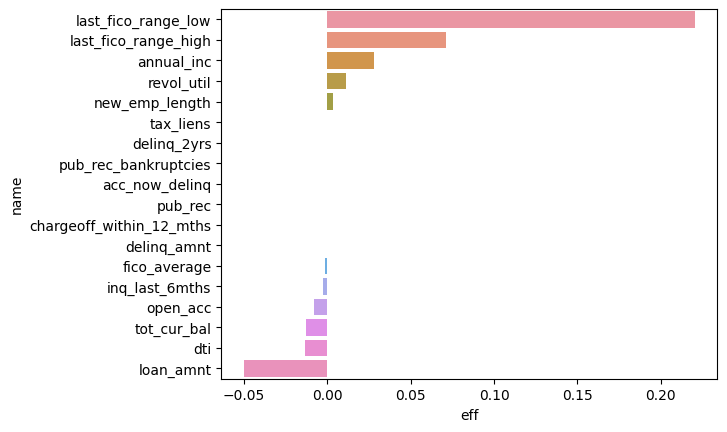

In [39]:
sns.barplot(y ='name',x='eff',data = final_coef)

## 실험결과 및 roccurve 그래프 확인하기

In [51]:
y_pred_proba = best_model.predict_proba(x_test)

In [ ]:
def new_conf(y, y_pred):
    real_pos_portion = confusion_matrix(y, y_pred)[0]/sum(confusion_matrix(y, y_pred)[0])
    real_neg_portion = confusion_matrix(y, y_pred)[1]/sum(confusion_matrix(y, y_pred)[1])
    return np.array([real_pos_portion, real_neg_portion])

def draw_cfmatrix(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ["Fullfill -> Fullfill", "Fullfill -> Charge off", "Charge off -> Fullfill", "Charge off -> Charge off"]
    group_counts = ["count: {0:0.0f}".format(value) for value in cf_matrix.flatten()]

    #여기서 새로운 cf matrix 적용
    cf_matrix = new_conf(y, y_pred)
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    ax.set(xlabel="predict class", ylabel="real class") #원래는 ax였음
    plt.show()

def plot_roc(y, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(y, y_pred_proba),3)),fontsize=16)
    plt.legend()
    plt.show()

def get_clf_eval(y , y_pred, y_pred_proba=None):
    confusion = confusion_matrix( y, y_pred)
    accuracy = accuracy_score(y , y_pred)
    precision = precision_score(y , y_pred)
    recall = recall_score(y , y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)

    print('오차 행렬')
    draw_cfmatrix(y , y_pred)
    print("ROC Curve")
    plot_roc(y, y_pred_proba)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, roc_auc: {3:.4f}'.format(accuracy , precision ,recall, roc_auc))

In [24]:
y_pred_proba = best_model.predict_proba(x_test)[:,1]
y_pred = best_model.predict(x_test)
get_clf_eval(y_test,y_pred,y_pred_proba)

NameError: name 'get_clf_eval' is not defined

In [26]:
np.where(y_pred_proba[:,1]>0.5,1,0)

array([0, 1, 0, ..., 0, 0, 0])

In [28]:
df.head()

NameError: name 'df' is not defined